### Plot zonal velocity at 4 transects along the Antarctic margin

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import numpy as np
import matplotlib.path as mpath
from scipy.io import loadmat
import mat73
from xgcm import Grid

import warnings
warnings.simplefilter("ignore")

from dask.distributed import Client
from dask.distributed import LocalCluster 

cluster = LocalCluster()
client = Client(cluster) 
client

distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-houa4dnk', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-8w265p4w', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-riaj_9p6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/net/Rebecca.Beadling/southern_ocean_fafmip/Beadling_2021_JGROceans_New/Figure_9/dask-worker-space/worker-5uz3aun6', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 30.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41873,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 30.94 GiB
Comm: tcp://127.0.0.1:41813,Total threads: 2
Dashboard: http://127.0.0.1:33269/status,Memory: 7.73 GiB
Nanny: tcp://127.0.0.1:43748,


### Load output for CM4 piControl Simulation -- add umo here

In [2]:
CM4_static_ocean = xr.open_dataset('/net/Rebecca.Beadling/subtropical_gyres/mode_water/ocean_monthly.static.nc')
CM4_u_cntrl = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/piControl_output/ocean_annual_z.0281-0380.uo.nc',
                             drop_variables=['average_DT', 'average_T1', 'average_T2'],use_cftime=True).sel(yh=slice(-90,-30)).chunk({'time':10,'yh':63})

### Load output for CM4 AntwaterStress members -- add umo here

In [3]:
AntwaterStress_vol_251 = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_output/ocean_annual_z.0001-0070.volcello.nc',
                                        drop_variables=['average_DT', 'average_T1', 'average_T2']
                                        ).sel(yh=slice(-90,-30)).isel(time=0)
AntwaterStress_u_251 = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_output/ocean_annual_z.0051-0070.uo.nc',
                                        drop_variables=['average_DT', 'average_T1', 'average_T2'],use_cftime=True).sel(yh=slice(-90,-30)).chunk({'time':10,'yh':63})

AntwaterStress_u_290 = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_290/ocean_annual_z.0051-0070.uo.nc',
                                        drop_variables=['average_DT', 'average_T1', 'average_T2'],use_cftime=True).sel(yh=slice(-90,-30)).chunk({'time':10,'yh':63})

AntwaterStress_u_332 = xr.open_dataset('/net2/Rebecca.Beadling/southern_ocean_fafmip/fafantwaterstress_332/ocean_annual_z.0051-0070.uo.nc',
                                        drop_variables=['average_DT', 'average_T1', 'average_T2'],use_cftime=True).sel(yh=slice(-90,-30)).chunk({'time':10,'yh':63})

### Compute Ensemble Mean

In [4]:
### Compute ensemble mean years 51 to 70 uo and volcello fields:
AntwaterStress_Ens_u = xr.concat([AntwaterStress_u_251,AntwaterStress_u_290,AntwaterStress_u_332],dim='member')
AntwaterStress_Ens_u_mean = AntwaterStress_Ens_u.uo.mean(dim=['member','time'])

### Define Antarctic Slope Current Transects

In [5]:
## 20E
asc_20e_AntwaterStress = AntwaterStress_Ens_u_mean.sel(yh=slice(-70.5,-68)).sel(xq=20,method='nearest')
asc_20e_cntrl = CM4_u_cntrl.sel(yh=slice(-70.5,-68)).sel(xq=20,method='nearest').mean(dim='time')
##150E
asc_150e_AntwaterStress = AntwaterStress_Ens_u_mean.sel(yh=slice(-69,-65.2)).sel(xq=-210,method='nearest')
asc_150e_cntrl = CM4_u_cntrl.sel(yh=slice(-69,-65.2)).sel(xq=-210,method='nearest').mean(dim='time')
##130W
asc_130w_AntwaterStress = AntwaterStress_Ens_u_mean.sel(yh=slice(-75,-72)).sel(xq=-130,method='nearest')
asc_130w_cntrl = CM4_u_cntrl.sel(yh=slice(-75,-72)).sel(xq=-130,method='nearest').mean(dim='time')
## 80W
asc_80w_AntwaterStress = AntwaterStress_Ens_u_mean.sel(yh=slice(-74,-68)).sel(xq=-80,method='nearest')
asc_80w_cntrl = CM4_u_cntrl.sel(yh=slice(-74,-68)).sel(xq=-80,method='nearest').mean(dim='time')

### Functions to plot models true bathymetry accounting for partial cells¶

In [57]:
## Cannot have NaNs to use as coordinate in pcolormesh:
def forward_fill(arr):
    """ Forward fill a 2-D array along the column dimension"""
    # make a copy of the input array
    out = arr * 1.0
    # loop over column index
    for col_idx in range(0,arr.shape[1]):
        # get the column to work on
        _row = arr[:,col_idx]
        # get index numbers of nan values
        _nan_vals = np.argwhere(np.isnan(_row))
        # find the last "good" value
        _depth = 0. if _nan_vals[0] == 0 else _row[_nan_vals[0]-1]
        # set nan values to the last good value
        _row = np.where(np.isnan(_row),_depth,_row)
        # re-assign the filled column
        out[:,col_idx] = _row
    return out

def depth_to_center_partial(arr):
    kmax = arr.shape[0]
    zl  = 0.0 * arr[:]                              
    zl[0] = 0.5 * arr[0] 
    
    k = 1
    while k < kmax:
        zl[k] = zl[k-1] + 0.5 * (arr[k]+arr[k-1])
        k=k+1
    
    zl_nm = np.array(zl)
    
    zl = forward_fill(zl_nm)
    
    return zl

## CM4 true bathymetry

In [64]:
import momlevel as ml
cm4_thk = ml.derived.calc_dz(AntwaterStress_vol_251.z_l,AntwaterStress_vol_251.z_i,CM4_static_ocean.deptho)
cm4_thk = cm4_thk.where(cm4_thk>0)

thk_20e_cm4 = cm4_thk.sel(xh=20,method='nearest').sel(yh=slice(-70.5,-68)).load()
lat_20e_cm4 = cm4_thk.yh.sel(yh=slice(-70.5,-68))

thk_150e_cm4 = cm4_thk.sel(xh=-210,method='nearest').sel(yh=slice(-69,-65.2)).load()
lat_150e_cm4 = cm4_thk.yh.sel(yh=slice(-69,-65.2))

thk_130w_cm4 = cm4_thk.sel(xh=-130,method='nearest').sel(yh=slice(-75,-72)).load()
lat_130w_cm4 = cm4_thk.yh.sel(yh=slice(-75,-72))

thk_80w_cm4 = cm4_thk.sel(xh=-80,method='nearest').sel(yh=slice(-74,-68)).load()
lat_80w_cm4 = cm4_thk.yh.sel(yh=slice(-74,-68))

zl_20e_cm4 = depth_to_center_partial(thk_20e_cm4)
zl_150e_cm4 = depth_to_center_partial(thk_150e_cm4)
zl_130w_cm4 = depth_to_center_partial(thk_130w_cm4)
zl_80w_cm4 = depth_to_center_partial(thk_80w_cm4)

lat_20e_cm4 = np.broadcast_to(lat_20e_cm4,zl_20e_cm4.shape)
lat_150e_cm4 = np.broadcast_to(lat_150e_cm4,zl_150e_cm4.shape)
lat_130w_cm4 = np.broadcast_to(lat_130w_cm4,zl_130w_cm4.shape)
lat_80w_cm4 = np.broadcast_to(lat_80w_cm4,zl_80w_cm4.shape)

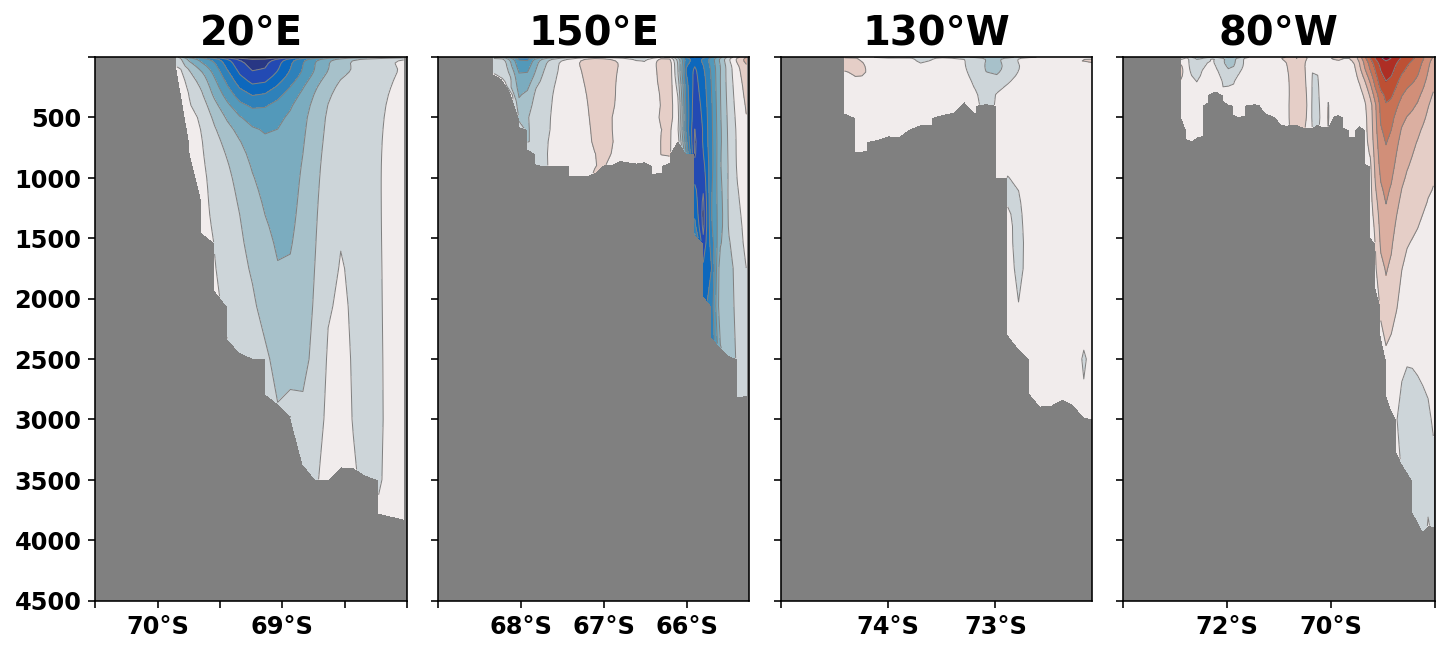

In [81]:
from matplotlib import gridspec

fig, ax = plt.subplots(1,4,figsize=(12,5))
gs = gridspec.GridSpec(1,4,wspace=0.1)
ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0],facecolor='grey'),\
                     plt.subplot(gs[0,1],facecolor='grey'),\
                     plt.subplot(gs[0,2],facecolor='grey'),\
                     plt.subplot(gs[0,3],facecolor='grey')

custom_ylim = (-4500,0)
plt.setp(ax1, ylim=custom_ylim, xlim=(-70.5,-68))
plt.setp(ax2, ylim=custom_ylim, xlim=(-69,-65.25))
plt.setp(ax3, ylim=custom_ylim, xlim=(-75,-72.10))
plt.setp(ax4, ylim=custom_ylim, xlim=(-74,-68))

levels_vel = np.linspace(-0.16,0.16,20)

ax1.contourf(lat_20e_cm4,-zl_20e_cm4,asc_20e_cntrl.uo.where(asc_20e_cntrl.uo != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax1.contour(lat_20e_cm4,-zl_20e_cm4,asc_20e_cntrl.uo.where(asc_20e_cntrl.uo != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax2.contourf(lat_150e_cm4,-zl_150e_cm4,asc_150e_cntrl.uo.where(asc_150e_cntrl.uo != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax2.contour(lat_150e_cm4,-zl_150e_cm4,asc_150e_cntrl.uo.where(asc_150e_cntrl.uo != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax3.contourf(lat_130w_cm4,-zl_130w_cm4,asc_130w_cntrl.uo.where(asc_130w_cntrl.uo != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax3.contour(lat_130w_cm4,-zl_130w_cm4,asc_130w_cntrl.uo.where(asc_130w_cntrl.uo != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax4.contourf(lat_80w_cm4,-zl_80w_cm4,asc_80w_cntrl.uo.where(asc_80w_cntrl.uo != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax4.contour(lat_80w_cm4,-zl_80w_cm4,asc_80w_cntrl.uo.where(asc_80w_cntrl.uo != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax1.yaxis.set_ticklabels([4500,4000,3500,3000,2500,2000,1500,1000,500],weight='bold',fontsize=12)
ax2.yaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])

ax1.xaxis.set_ticklabels(['','70\N{degree sign}S','','69\N{degree sign}S'],weight='bold',fontsize=12)
ax2.xaxis.set_ticklabels(['','68\N{degree sign}S','67\N{degree sign}S','66\N{degree sign}S'],weight='bold',fontsize=12)
ax3.xaxis.set_ticklabels(['','74\N{degree sign}S','73\N{degree sign}S'],weight='bold',fontsize=12)
ax4.xaxis.set_ticklabels(['','72\N{degree sign}S','70\N{degree sign}S'],weight='bold',fontsize=12)

ax1.set_title('20\N{degree sign}E',weight='bold',fontsize=20)
ax2.set_title('150\N{degree sign}E',weight='bold',fontsize=20)
ax3.set_title('130\N{degree sign}W',weight='bold',fontsize=20)
ax4.set_title('80\N{degree sign}W',weight='bold',fontsize=20)

plt.savefig('cm4_velocity_cross_sections_piControl_correct.pdf')

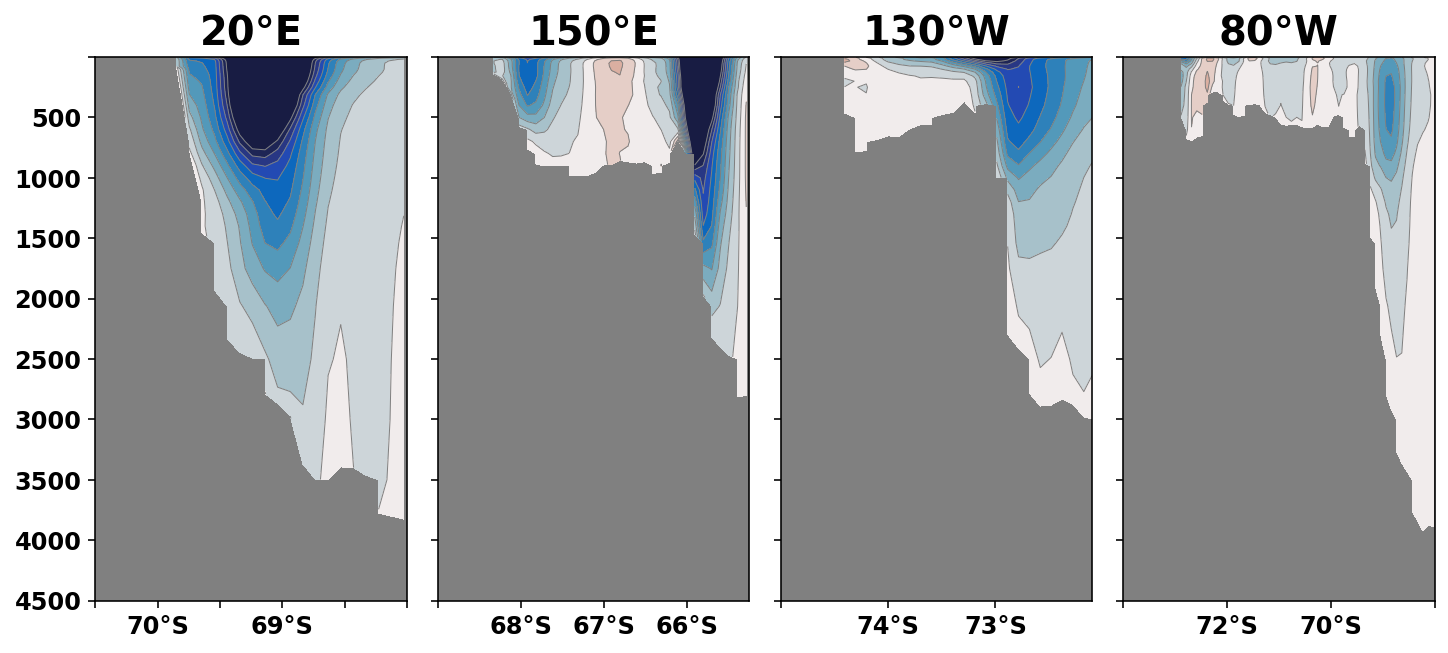

In [82]:
from matplotlib import gridspec

fig, ax = plt.subplots(1,4,figsize=(12,5))
gs = gridspec.GridSpec(1,4,wspace=0.1)
ax1, ax2, ax3, ax4 = plt.subplot(gs[0,0],facecolor='grey'),\
                     plt.subplot(gs[0,1],facecolor='grey'),\
                     plt.subplot(gs[0,2],facecolor='grey'),\
                     plt.subplot(gs[0,3],facecolor='grey')

custom_ylim = (-4500,0)
plt.setp(ax1, ylim=custom_ylim, xlim=(-70.5,-68))
plt.setp(ax2, ylim=custom_ylim, xlim=(-69,-65.25))
plt.setp(ax3, ylim=custom_ylim, xlim=(-75,-72.10))
plt.setp(ax4, ylim=custom_ylim, xlim=(-74,-68))

levels_vel = np.linspace(-0.16,0.16,20)

ax1.contourf(lat_20e_cm4,-zl_20e_cm4,asc_20e_AntwaterStress.where(asc_20e_AntwaterStress != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax1.contour(lat_20e_cm4,-zl_20e_cm4,asc_20e_AntwaterStress.where(asc_20e_AntwaterStress != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax2.contourf(lat_150e_cm4,-zl_150e_cm4,asc_150e_AntwaterStress.where(asc_150e_AntwaterStress != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax2.contour(lat_150e_cm4,-zl_150e_cm4,asc_150e_AntwaterStress.where(asc_150e_AntwaterStress != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax3.contourf(lat_130w_cm4,-zl_130w_cm4,asc_130w_AntwaterStress.where(asc_130w_AntwaterStress != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax3.contour(lat_130w_cm4,-zl_130w_cm4,asc_130w_AntwaterStress.where(asc_130w_AntwaterStress != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax4.contourf(lat_80w_cm4,-zl_80w_cm4,asc_80w_AntwaterStress.where(asc_80w_AntwaterStress != 0).values,
             levels=levels_vel,
             cmap=cmocean.cm.balance,
             extend='both',
             corner_mask=False)
ax4.contour(lat_80w_cm4,-zl_80w_cm4,asc_80w_AntwaterStress.where(asc_80w_AntwaterStress != 0).values,
             levels=levels_vel,
             colors='grey',
             extend='both',
             linestyles='-',linewidths=0.5,
             corner_mask=False)

ax1.yaxis.set_ticklabels([4500,4000,3500,3000,2500,2000,1500,1000,500],weight='bold',fontsize=12)
ax2.yaxis.set_ticklabels([])
ax3.yaxis.set_ticklabels([])
ax4.yaxis.set_ticklabels([])

ax1.xaxis.set_ticklabels(['','70\N{degree sign}S','','69\N{degree sign}S'],weight='bold',fontsize=12)
ax2.xaxis.set_ticklabels(['','68\N{degree sign}S','67\N{degree sign}S','66\N{degree sign}S'],weight='bold',fontsize=12)
ax3.xaxis.set_ticklabels(['','74\N{degree sign}S','73\N{degree sign}S'],weight='bold',fontsize=12)
ax4.xaxis.set_ticklabels(['','72\N{degree sign}S','70\N{degree sign}S'],weight='bold',fontsize=12)

ax1.set_title('20\N{degree sign}E',weight='bold',fontsize=20)
ax2.set_title('150\N{degree sign}E',weight='bold',fontsize=20)
ax3.set_title('130\N{degree sign}W',weight='bold',fontsize=20)
ax4.set_title('80\N{degree sign}W',weight='bold',fontsize=20)

plt.savefig('cm4_velocity_cross_sections_AntwaterStress_correct.pdf')